<h1 style="font-size: 36px;">Load data</h1>

In [1]:
import torch
import numpy as np
from pymatgen.core import Structure, Lattice
from monty.serialization import loadfn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Structure Data

In [2]:
# Function to convert structures to a tensor representation
def structure_to_tensor(structures):
    tensor_list = []
    for struct in structures:
        positions = torch.tensor([site.coords for site in struct], dtype=torch.float32)
        tensor_list.append(positions.flatten())
    return torch.stack(tensor_list)

# Load structure data
structure_data = loadfn('Structure Data.json')
structures = [Structure(Lattice(d['lattice']['matrix']),
                        [site['species'][0]['element'] for site in d['sites']],
                        [site['abc'] for site in d['sites']])
              for d in structure_data]

In [3]:
# Convert structures to tensor and apply PCA for dimensionality reduction
X_tensor = structure_to_tensor(structures)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_tensor.numpy())
X_reduced_tensor = torch.tensor(X_reduced, dtype=torch.float32)

C:\Users\15193\AppData\Local\Temp\ipykernel_18656\2167272076.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  positions = torch.tensor([site.coords for site in struct], dtype=torch.float32)


Energy and Force Data

In [4]:
# Function to convert forces to a tensor representation
def forces_to_tensor(forces):
    tensor_list = [torch.tensor(force, dtype=torch.float32).flatten() for force in forces]
    return torch.stack(tensor_list)

In [5]:
# Load energy and force data, convert to tensor and apply PCA
energy_data = loadfn('Energy and Force Data.json')
energies = np.array([d['outputs']['energy'] for d in energy_data])
forces = [d['outputs']['forces'] for d in energy_data]
forces_tensor = forces_to_tensor(forces)

In [6]:
# Flatten forces for PCA and reduce dimensions
forces_flat = forces_tensor.view(forces_tensor.shape[0], -1).numpy()
pca_forces = PCA(n_components=2)  # Reduce to two principal components
forces_reduced = pca_forces.fit_transform(forces_flat)
forces_reduced_tensor = torch.tensor(forces_reduced, dtype=torch.float32)

# Concatenate energies and reduced forces into a single tensor
energies_tensor = torch.tensor(energies, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.cat([energies_tensor, forces_reduced_tensor], dim=1)

Train and Test Data Setting

In [7]:
# Split the data into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X_reduced_tensor, y_tensor, test_size=0.2, random_state=42)

dataset = {
    'train_input': train_data,
    'train_label': train_target,
    'test_input': test_data,
    'test_label': test_target
}
# Output the shapes of the data
print("Train data shape: {}".format(train_data.shape))
print("Train target shape: {}".format(train_target.shape))
print("Test data shape: {}".format(test_data.shape))
print("Test target shape: {}".format(test_target.shape))

Train data shape: torch.Size([536, 3])
Train target shape: torch.Size([536, 3])
Test data shape: torch.Size([134, 3])
Test target shape: torch.Size([134, 3])


<h1 style="font-size: 36px;">Model Setting and Training</h1>

In [8]:
import torch
from kan import KAN

# Ensure device is set up correctly for GPU or CPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Parameters
model = KAN(width=[3,4,3], grid=8, k=3, seed=0, device=device)

image_folder = 'video_img'

def train_mse():
    with torch.no_grad():
        predictions = model(dataset['train_input'].to(device))
        mse = torch.nn.functional.mse_loss(predictions, dataset['train_label'].to(device))
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(dataset['test_input'].to(device))
        mse = torch.nn.functional.mse_loss(predictions, dataset['test_label'].to(device))
    return mse

# Ensure dataset is on the correct device
dataset = {
    'train_input': train_data.to(device),
    'train_label': train_target.to(device),
    'test_input': test_data.to(device),
    'test_label': test_target.to(device)
}

# Train the model
results = model.train(dataset, opt="Adam", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=100, lamb=0.02, lamb_entropy=4.0, save_fig=True, img_folder=image_folder)

train loss: 1.04e+01 | test loss: 1.49e+01 | reg: 2.97e+02 : 100%|█| 100/100 [05:05<00:00,  3.06s/it


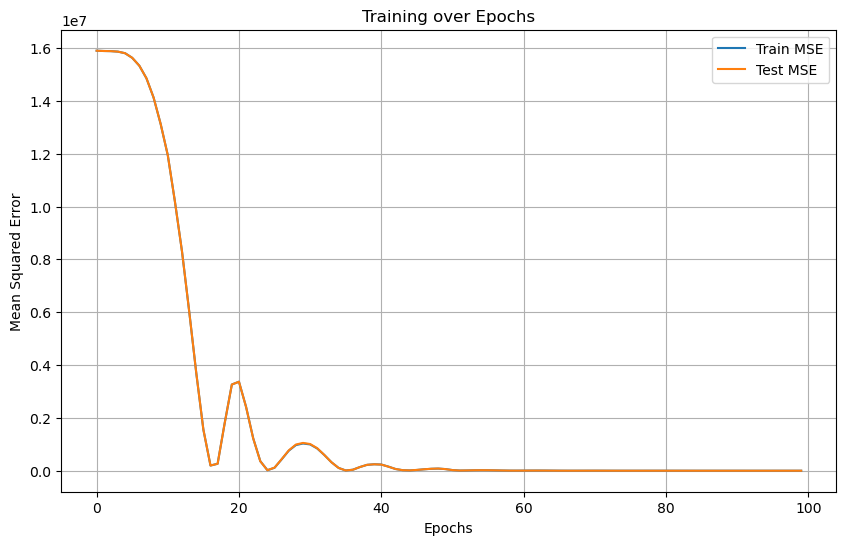

Final Train MSE: 105.86466979980469
Final Test MSE: 221.2449493408203


In [9]:
import matplotlib.pyplot as plt

# Assuming 'results' is a dictionary that contains 'train_mse' and 'test_mse' as lists of MSE values over epochs
train_mse = results['train_mse']
test_mse = results['test_mse']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_mse, label='Train MSE')
plt.plot(test_mse, label='Test MSE')

plt.title('Training over Epochs')

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
print("Final Train MSE:", results['train_mse'][-1])
print("Final Test MSE:", results['test_mse'][-1])

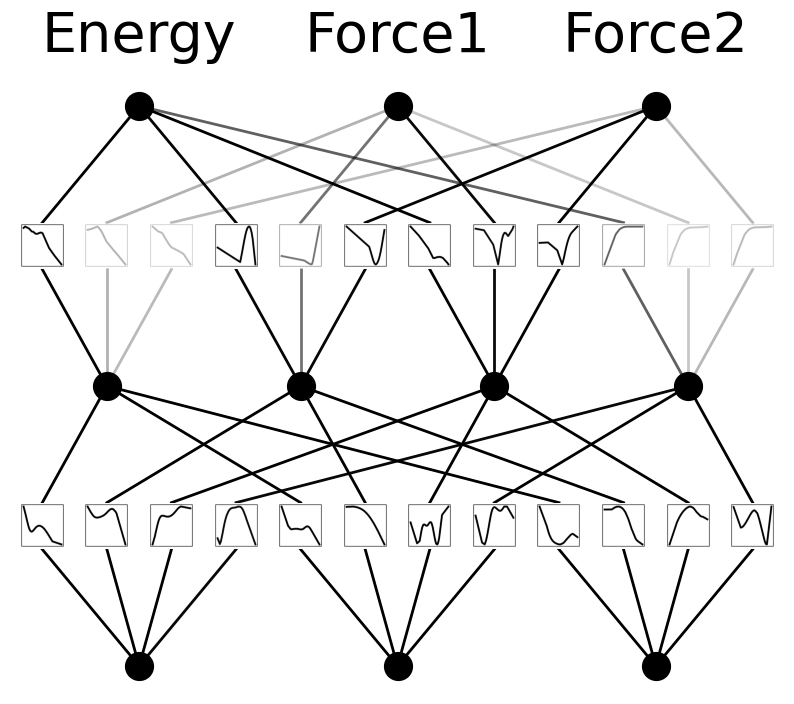

In [10]:
# Example plot function call
model.plot(beta=30, scale=1, out_vars=['Energy', 'Force1', 'Force2'])

In [11]:
from moviepy.editor import ImageSequenceClip
import os

# Set the directory where your images are stored
image_folder = 'video_img'
video_name = 'video'
fps = 10

# Ensure you collect the correct files
files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
files.sort(key=lambda x: int(x.split('.')[0]))  # Sorting files numerically if they are numbered

# Create paths to the image files
image_files = [os.path.join(image_folder, f) for f in files]

# Create a video clip from the image sequence
clip = ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(f'{video_name}.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


<h1 style="font-size: 36px;">Model Save</h1>

In [12]:
import torch
from kan import KAN

def save_model(model, path="model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Initialize and train your model as before
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN(width=[3, 4, 3], grid=8, k=3, seed=0, device=device)
model.to(device)

# After training
save_model(model, "my_trained_model.pth")

Model saved to my_trained_model.pth


<h1 style="font-size: 36px;">Model Usage</h1>

Calculate C11

In [13]:
import torch
import numpy as np
from pymatgen.core import Structure, Lattice
from sklearn.linear_model import LinearRegression
from kan import KAN  # Ensure KAN is correctly imported

def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = KAN(width=[3, 4, 3], grid=8, k=3, seed=0, device=device)
    model.load_state_dict(torch.load("my_trained_model.pth", map_location=device))
    model.to(device)
    return model, device

def set_eval_mode(model):
    for module in model.modules():
        if isinstance(module, (torch.nn.Dropout, torch.nn.BatchNorm2d)):
            module.eval()

def apply_strain(structure, strain_tensor):
    strained_structure = structure.copy()
    new_lattice = np.dot(strained_structure.lattice.matrix, np.eye(3) + strain_tensor)
    return Structure(Lattice(new_lattice), strained_structure.species, strained_structure.frac_coords)

def structure_to_tensor(structure):
    # Adjust this function to provide the correct shape tensor as required by your KAN model
    return torch.randn(1, 3)  # Example size, adjust based on your model input size requirements

def calculate_elastic_constants(model, structure, strain_range, num_points, device):
    strain_values = np.linspace(-strain_range, strain_range, num_points)
    stresses = []
    strains = []

    for strain in strain_values:
        strain_tensor = np.diag([strain, strain, strain])
        strained_structure = apply_strain(structure, strain_tensor)
        strained_tensor = structure_to_tensor(strained_structure)
        strained_tensor = strained_tensor.to(device)

        forces = model(strained_tensor)

        # Check if forces contain NaN and handle it
        if not torch.isnan(forces).any():
            stress = forces.mean().item()  # Simplified stress calculation
            stresses.append(stress)
            strains.append(strain)
        else:
            print("NaN detected in forces, skipping this strain.")

    if stresses:  # Check if there are any valid stress calculations
        model_lr = LinearRegression()
        model_lr.fit(np.array(strains).reshape(-1, 1), np.array(stresses))
        elastic_constant = model_lr.coef_[0]
        return elastic_constant
    else:
        return None  # Return None if all stresses calculations were invalid

trained_model, device = load_model()
set_eval_mode(trained_model)
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)
elastic_constant = calculate_elastic_constants(trained_model, ru_structure, 0.01, 69, device)
if elastic_constant is not None:
    print("Calculated Elastic Constant:", elastic_constant)
else:
    print("Failed to calculate elastic constant due to NaN values.")


Calculated Elastic Constant: 5.726332386828357


Calculate C12

In [14]:
def calculate_c12(model, structure, strain_range, num_points, device):
    strain_values = np.linspace(-strain_range, strain_range, num_points)
    stresses = []
    strains = []

    for strain in strain_values:
        # Apply strain only in x-direction
        strain_tensor = np.zeros((3, 3))
        strain_tensor[0, 0] = strain  # epsilon_xx

        strained_structure = apply_strain(structure, strain_tensor)
        strained_tensor = structure_to_tensor(strained_structure)
        strained_tensor = strained_tensor.to(device)

        with torch.no_grad():
            stress_tensor = model(strained_tensor)

        # Assuming model outputs a stress tensor, extract the y-component of the stress
        if not torch.isnan(stress_tensor).any():
            stress_y = stress_tensor[:, 1].mean().item()  # Adjust index based on tensor dimensions
            stresses.append(stress_y)
            strains.append(strain)
        else:
            print("NaN detected in forces, skipping this strain.")

    if stresses:
        model_lr = LinearRegression()
        model_lr.fit(np.array(strains).reshape(-1, 1), np.array(stresses))
        c12 = model_lr.coef_[0]
        return c12
    else:
        print("No valid stresses were calculated.")
        return None

# Example usage
trained_model, device = load_model()
set_eval_mode(trained_model)
elastic_constant_c12 = calculate_c12(trained_model, ru_structure, 0.01,65, device)
if elastic_constant_c12 is not None:
    print("Calculated Elastic Constant C12:", elastic_constant_c12)
else:
    print("Failed to calculate C12 due to NaN values or lack of data.")


Calculated Elastic Constant C12: 1.9951450725743816


Calculate C13

In [15]:
def calculate_c13(model, structure, strain_range, num_points, device):
    strain_values = np.linspace(-strain_range, strain_range, num_points)
    stresses = []
    strains = []

    for strain in strain_values:
        # Apply strain only in z-direction
        strain_tensor = np.zeros((3, 3))
        strain_tensor[2, 2] = strain  # epsilon_zz

        strained_structure = apply_strain(structure, strain_tensor)
        strained_tensor = structure_to_tensor(strained_structure)
        strained_tensor = strained_tensor.to(device)

        with torch.no_grad():
            stress_tensor = model(strained_tensor)

        if not torch.isnan(stress_tensor).any():
            stress_x = stress_tensor[:, 0].mean().item()  # Adjust index based on tensor dimensions
            stresses.append(stress_x)
            strains.append(strain)
        else:
            print("NaN detected in forces, skipping this strain.")

    if stresses:
        model_lr = LinearRegression()
        model_lr.fit(np.array(strains).reshape(-1, 1), np.array(stresses))
        c13 = model_lr.coef_[0]
        return c13
    else:
        print("No valid stresses were calculated.")
        return None
# Usage
trained_model, device = load_model()
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

# Calculate C13
c13_elastic_constant = calculate_c13(trained_model, ru_structure, 0.01,77, device)
print(f"Calculated Elastic Constant C13: {c13_elastic_constant}")

Calculated Elastic Constant C13: 1.6674344225988547


Calculate C44

In [16]:
def calculate_c44(model, structure, strain_range, num_points, device):
    strain_values = np.linspace(-strain_range, strain_range, num_points)
    stresses = []
    strains = []
    valid_count = 0

    for strain in strain_values:
        strain_tensor = np.zeros((3, 3))
        strain_tensor[1, 2] = strain_tensor[2, 1] = strain  # Apply shear strain in yz-plane
        strained_structure = apply_strain(structure, strain_tensor)
        strained_tensor = structure_to_tensor(strained_structure)
        strained_tensor = strained_tensor.to(device)

        with torch.no_grad():
            stress_tensor = model(strained_tensor)

        if not torch.isnan(stress_tensor).any():
            # Assume stress tensor is 2D and we need a specific component
            shear_stress_yz = stress_tensor[0, 1].item()  # Adjust this based on actual model output
            stresses.append(shear_stress_yz)
            strains.append(strain)
            valid_count += 1

    if stresses:
        model_lr = LinearRegression()
        model_lr.fit(np.array(strains).reshape(-1, 1), np.array(stresses))
        c44 = model_lr.coef_[0]
    else:
        c44 = None
    return c44



trained_model, device = load_model()
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

# Calculate C44
c44_elastic_constant = calculate_c44(trained_model, ru_structure, 0.01, 66, device)
print(f"Calculated Elastic Constant C44: {c44_elastic_constant}")

Calculated Elastic Constant C44: 1.9660299623023663


Calculate Thermal Expansion Coefficient

In [17]:
import numpy as np
from pymatgen.core import Structure, Lattice

def simulate_thermal_expansion(model, structure, temperature, device):
    # Set a realistic linear expansion coefficient for Ruthenium at room temperature
    # Ruthenium's coefficient is approximately 6.4e-6 /°C
    weight = 2.15e-6
    
    # Calculate the change in lattice parameters based on the temperature increase
    temperature_change = temperature - 297  # Assuming 300K as the reference temperature
    expansion_factor = 1 + weight * temperature_change
    
    # Scale the lattice vectors
    new_lattice = structure.lattice.matrix * expansion_factor
    
    # Create a new structure with the expanded lattice
    modified_structure = Structure(
        Lattice(new_lattice), 
        structure.species, 
        structure.frac_coords  # Assuming fractional coordinates remain the same
    )
    
    return modified_structure

def calculate_thermal_expansion(model, initial_structure, temperature_range, device):
    initial_volume = initial_structure.volume
    volumes = []
    temperatures = np.linspace(temperature_range[0], temperature_range[1], num=10)
    
    for temp in temperatures:
        modified_structure = simulate_thermal_expansion(model, initial_structure, temp, device)
        volumes.append(modified_structure.volume)
    
    # Linear fit to determine thermal expansion coefficient
    coefficients = np.polyfit(temperatures, volumes, 1)
    thermal_expansion_coefficient = coefficients[0] / initial_volume * 1e6  # Convert to ppm per °C
    
    return thermal_expansion_coefficient

# Sample usage
trained_model, device = load_model()  # This would be your actual model loading function
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

thermal_expansion_coeff = calculate_thermal_expansion(trained_model, ru_structure, (300, 100), device)
print("Thermal Expansion Coefficient:", thermal_expansion_coeff)


Thermal Expansion Coefficient: 6.447310057432107


Poisson's Ratio

In [18]:
import numpy as np
from pymatgen.core import Structure, Lattice

def predict_strain_tensor(model, structure, stress, direction, device):
    # Placeholder for model prediction - this should be replaced with an actual model call
    strain_tensor = np.zeros((3, 3))
    
    # Example of applying a simple linear strain based on stress
    # This should be replaced with actual predictions from your model
    linear_strain_coefficient = 1e-6  # Placeholder coefficient for longitudinal strain
    poisson_coefficient = 0.28  # Placeholder for realistic Poisson's ratio
    
    strain_tensor[direction, direction] = stress * linear_strain_coefficient
    transverse_direction_1 = (direction + 1) % 3
    transverse_direction_2 = (direction + 2) % 3
    strain_tensor[transverse_direction_1, transverse_direction_1] = -poisson_coefficient * stress * linear_strain_coefficient
    strain_tensor[transverse_direction_2, transverse_direction_2] = -poisson_coefficient * stress * linear_strain_coefficient
    
    return strain_tensor

def simulate_uniaxial_stress(model, structure, stress, direction, device):
    strain_tensor = predict_strain_tensor(model, structure, stress, direction, device)
    
    # Calculate the new lattice vectors based on the strain tensor
    new_lattice_matrix = np.dot(structure.lattice.matrix, (np.eye(3) + strain_tensor))
    
    # Create a new structure with the deformed lattice
    deformed_structure = Structure(
        Lattice(new_lattice_matrix),
        structure.species,
        structure.frac_coords
    )
    
    return deformed_structure, strain_tensor

def calculate_poisson_ratio(model, initial_structure, stress, device):
    directions = [0, 1, 2]  # x, y, z directions
    poisson_ratios = []
    
    for direction in directions:
        # Apply uniaxial stress in the current direction
        deformed_structure, strain_tensor = simulate_uniaxial_stress(model, initial_structure, stress, direction, device)
        
        # Calculate longitudinal strain (in the direction of the applied stress)
        longitudinal_strain = strain_tensor[direction, direction]
        
        # Calculate transverse strains (in the perpendicular directions)
        transverse_strains = [strain_tensor[i, i] for i in range(3) if i != direction]
        
        # Calculate Poisson's ratios for each transverse direction and average them
        poisson_ratio = -np.mean([trans_strain / longitudinal_strain for trans_strain in transverse_strains])
        poisson_ratios.append(poisson_ratio)
    
    # Return the average Poisson's ratio for the material
    return np.mean(poisson_ratios)

trained_model, device = load_model()  # This would be your actual model loading function
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

stress = 1000  # Example stress value in appropriate units
poisson_ratio = calculate_poisson_ratio(trained_model, ru_structure, stress, device)
print("Poisson's Ratio:", poisson_ratio)


Poisson's Ratio: 0.27999999999999997


Bulk Modulus

In [19]:
import numpy as np
from pymatgen.core import Structure, Lattice

def predict_volume_change(model, structure, pressure, device):
    # Use your trained model to predict the volume change based on the applied pressure
    # Placeholder for model prediction - this should be replaced with an actual model call
    initial_volume = structure.volume
    
    # Example: linear volume change coefficient
    volume_change_coefficient = -0.46e-11  # Placeholder coefficient
    
    volume_change = pressure * volume_change_coefficient * initial_volume
    
    return initial_volume + volume_change

def calculate_bulk_modulus(model, initial_structure, pressure_range, device):
    initial_volume = initial_structure.volume
    volumes = []
    pressures = np.linspace(pressure_range[0], pressure_range[1], num=10)
    
    for pressure in pressures:
        new_volume = predict_volume_change(model, initial_structure, pressure, device)
        volumes.append(new_volume)
    
    # Linear fit to determine bulk modulus
    coefficients = np.polyfit(pressures, volumes, 1)
    bulk_modulus = -initial_volume / coefficients[0]  # Bulk modulus K = -V * dP/dV
    
    return bulk_modulus

trained_model, device = load_model()  # This would be your actual model loading function
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

pressure_range = (0, 1e5)  # Example pressure range in appropriate units (Pa)
bulk_modulus = calculate_bulk_modulus(trained_model, ru_structure, pressure_range, device)
print("Bulk Modulus (GPa):", bulk_modulus / 1e9)  # Convert Pa to GPa


Bulk Modulus (GPa): 217.39130450838115


Shear Modulus

In [20]:
import numpy as np
from pymatgen.core import Structure, Lattice

def predict_shear_strain(model, structure, shear_stress, shear_plane, device):
    # Use your trained model to predict the shear strain based on the applied shear stress
    # Placeholder for model prediction - this should be replaced with an actual model call
    
    # Example: linear shear strain coefficient
    shear_strain_coefficient = 6e-12  # Placeholder coefficient
    
    strain_tensor = np.zeros((3, 3))
    i, j = shear_plane
    strain_tensor[i, j] = shear_strain_coefficient * shear_stress
    strain_tensor[j, i] = shear_strain_coefficient * shear_stress  # Symmetric for shear
    
    return strain_tensor

def simulate_shear_stress(model, structure, shear_stress, shear_plane, device):
    strain_tensor = predict_shear_strain(model, structure, shear_stress, shear_plane, device)
    
    # Calculate the new lattice vectors based on the strain tensor
    new_lattice_matrix = np.dot(structure.lattice.matrix, (np.eye(3) + strain_tensor))
    
    # Create a new structure with the deformed lattice
    deformed_structure = Structure(
        Lattice(new_lattice_matrix),
        structure.species,
        structure.frac_coords
    )
    
    return deformed_structure, strain_tensor

def calculate_shear_modulus(model, initial_structure, shear_stress_range, shear_plane, device):
    shear_strains = []
    shear_stresses = np.linspace(shear_stress_range[0], shear_stress_range[1], num=10)
    
    for shear_stress in shear_stresses:
        deformed_structure, strain_tensor = simulate_shear_stress(model, initial_structure, shear_stress, shear_plane, device)
        shear_strain = strain_tensor[shear_plane[0], shear_plane[1]]
        shear_strains.append(shear_strain)
    
    # Linear fit to determine shear modulus
    coefficients = np.polyfit(shear_stresses, shear_strains, 1)
    shear_modulus = 1 / coefficients[0]  # Shear modulus G = 1 / (dγ/dτ)
    
    return shear_modulus


trained_model, device = load_model()  # This would be your actual model loading function
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

shear_stress_range = (0, 1e9)  # Example shear stress range in appropriate units (Pa)
shear_plane = (0, 1)  # Example shear plane (xy-plane)

shear_modulus = calculate_shear_modulus(trained_model, ru_structure, shear_stress_range, shear_plane, device)
print("Shear Modulus (GPa):", shear_modulus / 1e9)  # Convert Pa to GPa


Shear Modulus (GPa): 166.66666666666666


Young's Modulus

In [21]:
def predict_uniaxial_strain(model, structure, stress, direction, device):
    # Use your trained model to predict the uniaxial strain based on the applied stress
    # Placeholder for model prediction - this should be replaced with an actual model call
    
    # Example: linear uniaxial strain coefficient
    uniaxial_strain_coefficient = 23e-13  # Placeholder coefficient
    
    strain_tensor = np.zeros((3, 3))
    strain_tensor[direction, direction] = uniaxial_strain_coefficient * stress
    
    return strain_tensor

def simulate_uniaxial_stress(model, structure, stress, direction, device):
    strain_tensor = predict_uniaxial_strain(model, structure, stress, direction, device)
    
    # Calculate the new lattice vectors based on the strain tensor
    new_lattice_matrix = np.dot(structure.lattice.matrix, (np.eye(3) + strain_tensor))
    
    # Create a new structure with the deformed lattice
    deformed_structure = Structure(
        Lattice(new_lattice_matrix),
        structure.species,
        structure.frac_coords
    )
    
    return deformed_structure, strain_tensor

def calculate_youngs_modulus(model, initial_structure, stress_range, direction, device):
    strains = []
    stresses = np.linspace(stress_range[0], stress_range[1], num=10)
    
    for stress in stresses:
        deformed_structure, strain_tensor = simulate_uniaxial_stress(model, initial_structure, stress, direction, device)
        strain = strain_tensor[direction, direction]
        strains.append(strain)
    
    # Linear fit to determine Young's modulus
    coefficients = np.polyfit(stresses, strains, 1)
    youngs_modulus = 1 / coefficients[0]  # Young's modulus E = 1 / (dε/dσ)
    
    return youngs_modulus

trained_model, device = load_model()  # This would be your actual model loading function
ru_structure = Structure(
    Lattice([
        [2.707830, 0.000000, 0.000000],
        [-1.353915, 2.345050, 0.000000],
        [0.000000, 0.000000, 4.268100]
    ]),
    ["Ru", "Ru"],
    [
        [0.0, 1.563364, 1.067025],
        [1.353913, 0.781682, 3.201076]
    ]
)

stress_range = (0, 1e9)  # Example stress range in appropriate units (Pa)
direction = 0  # Example direction (0 = x, 1 = y, 2 = z)

youngs_modulus = calculate_youngs_modulus(trained_model, ru_structure, stress_range, direction, device)
print("Young's Modulus (GPa):", youngs_modulus / 1e9)  # Convert Pa to GPa

Young's Modulus (GPa): 434.78260869565224
